# Cleaning vehicles claims data

### Assumptions
- Only considering monthly claims data
- Limit claims data to `Motor Commercial`
- Negative `Sum_Insured` & `cm_gross` assumed bad data
- `Premium < 10` assumed bad data
- `vehicleCategory` is not ordinal

### Imports and general notebook settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime 
import joblib
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, KBinsDiscretizer # feature engineering
import mlflow

pd.set_option('display.max_columns', 500)

#### Read in data

In [2]:
relative_dir = "/Users/Sam/Documents/Financial Services/Mobility/"

df_raw = pd.read_excel(F"{relative_dir}ml_dataset.xlsx", header = 0, decimal='.')

### Clean Features
#### Identify numeric/categorical features & remove whitespace

In [3]:
#categorical (str) features
cat_features = []
for col in df_raw.columns.to_list():
    if df_raw[col].dtype == "object":
        cat_features.append(col)
        
#remove leading & trailing whitespace
for c in cat_features:
    df_raw.loc[:,c] = df_raw[c].str.strip()        

#### Some manual filters

In [4]:
#feature filter
relevant_cols = ["exposure_month","exposure_year","cm_policyholder", "CoverType", "StartDate","EndDate","AccVehicleTypeDesc",
                 "vehicleCategory","City","PolicyType","Vehicle_RegNo","Vehicle_Year","Vehicle_Make", "Vehicle_Model",
                 "Sum_Insured","ItemUniqueGUID","Premium","cm_gross","cm_clm_no","DateOfLoss"]

#map vehicles type
vehicle_map = {'Bus':'Bus',
               'Bus - seats incl. driver < 40 for reward':'Bus',
               'Caravans':'Trailer/Caravan',
               'Trailers':'Trailer/Caravan',
               'Earth Moving Tractors':'Tractor',
               'Tractor':'Tractor',
               'Excavators':'Excavator/Forklift',
               'Forklift':'Excavator/Forklift',
               'Heavy Commercial Vehicles':'Commercial Vehicle',
               'LDV (Commercial Use)':'Commercial Vehicle',
               'LDVs > 1500 kgs':'Commercial Vehicle',
               'Private / LDV':'Commercial Vehicle',
               'Special Types':'Commercial Vehicle',
               'Vehicles > 3500Kg':'Commercial Vehicle',
               'Motor cycles - exceeding 1000cc':'Motorcycle',
               'Motorcycles':'Motorcycle',
               'Vehicles < 3500Kg':'Vehicle < 3500Kg'}

#manually set the AccVehicleTypeDesc
df_raw.loc[(df_raw['Vehicle_Model'] == "FH520 GLOBETROTTER"), 'AccVehicleTypeDesc'] = "Heavy Commercial Vehicles"

#fix misspelling
df_raw.rename(columns = {'eposure_month':'exposure_month'}, inplace = True)

#### Filter data based on assumptions

In [5]:
#keep only relevant cols
df_filter = df_raw[relevant_cols]

#keep only Motor Commercial
df_filter = df_filter[df_filter['CoverType']=='Motor Commercial']

#remap vehicle category (replace ordinal feature)
df_filter['vehicleCategory'] = df_filter['AccVehicleTypeDesc'].map(vehicle_map)

#set claims NaN values to 0
df_filter["cm_gross"] = df_filter["cm_gross"].replace({np.nan:0})

#filter out small premiums, 
df_filter = df_filter[(df_filter['Premium'] > 10) & (df_filter['Sum_Insured'] > 0) & (df_filter['cm_gross'] >= 0)]

#filter policy type (months)
df_filter = df_filter[df_filter['PolicyType']=='Monthly']

#drop columns
df_filter = df_filter.drop(['CoverType','AccVehicleTypeDesc','PolicyType'], axis=1)

In [6]:
#numeric features
num_features = []
for col in df_filter.columns.to_list():
    if df_filter[col].dtype == "float64":
        num_features.append(col)

#### Check distributions of numeric features

In [7]:
df_filter.describe()

,exposure_year,Vehicle_Year,Sum_Insured,Premium,cm_gross
count,95207.000000,95207.000000,9.520700e+04,95207.000000,9.520700e+04
mean,2021.381590,2014.590797,5.576808e+05,1140.970671,8.091892e+02
std,0.610557,7.497160,5.832242e+05,1587.912217,1.898196e+04
min,2020.000000,1900.000000,1.700000e+03,11.460000,0.000000e+00
25%,2021.000000,2012.000000,1.949000e+05,218.750000,0.000000e+00
50%,2021.000000,2016.000000,3.000000e+05,487.500000,0.000000e+00
75%,2022.000000,2019.000000,7.000000e+05,1250.000000,0.000000e+00
max,2022.000000,2022.000000,6.072920e+06,15000.000000,1.681278e+06


#### Min Vehicle_Year doesn't make sense - set to median

In [8]:
#set vehicle year to median
df_filter.loc[(df_filter['Vehicle_Year'] == 1900), 'Vehicle_Year'] = df_filter['Vehicle_Year'].median()

#### Search for duplicates

In [9]:
df_filter.drop_duplicates(subset=['exposure_month','StartDate','EndDate','Vehicle_RegNo','ItemUniqueGUID','cm_gross','cm_clm_no'], inplace=True)

In [10]:
test = df_filter.groupby(by=['exposure_month','StartDate','EndDate','Vehicle_RegNo','ItemUniqueGUID','cm_clm_no'], as_index=False).size()

In [11]:
test[test['size']!=1].head()

,exposure_month,StartDate,EndDate,Vehicle_RegNo,ItemUniqueGUID,cm_clm_no,size
25,2020-10-01,2020-10-01,2020-10-31,HZD522MP,c52c5a2b-c886-4756-a866-50a20ecb2b8d,LOMBARD-LIB0002-1506-00000002,2
67,2020-11-01,2020-11-01,2020-11-30,KDK538MP,03140b7f-a040-4603-aa88-5f9cc182c014,LOMBARD-LIB0002-769-00000012,2
82,2020-12-01,2020-12-01,2020-12-31,HZM553MP,e6ef3429-9bc2-4517-a70b-9505f4986a5d,LOMBARD-LIB0002-1506-00000012,2
126,2021-01-01,2021-01-01,2021-01-31,ND775154,e583cd03-59b3-4a2d-a6fb-3179ae4607b1,LOMBARD-LIB0002-2451-00000006,2
131,2021-02-01,2021-02-01,2021-02-28,CA920749,dfd0cad7-47d2-4a9d-ada2-32ea01cd9f72,LOMBARD-LIB0002-2934-00000023,2


In [12]:
df_filter[(df_filter['Vehicle_RegNo']=='JF66JVGP') & (df_filter['exposure_month']=='2020-10-01')]

,exposure_month,exposure_year,cm_policyholder,StartDate,EndDate,vehicleCategory,City,Vehicle_RegNo,Vehicle_Year,Vehicle_Make,Vehicle_Model,Sum_Insured,ItemUniqueGUID,Premium,cm_gross,cm_clm_no,DateOfLoss
85588,2020-10-01,2020,VTN Investments (PTY) Ltd including Sub Contra...,2020-10-01,2020-10-31,Trailer/Caravan,KLIPRIVIER,JF66JVGP,2012.0,AFRIT INTERLINK TAUTLINER,trailer,200000.0,4eb0a8c7-efa3-4655-a58c-22047685cf9e,403.329987,147826.09375,LOMBARD-LIB0002-1819-00000020,2020-10-25


### Other things to try: 
- Feature engineering (vehicle age in years)
- Imputing missing City feature from number plates
- Removing severe outliers (premiums over 10k, claims over 500k, insured about over 400k)
- Clean Model feature


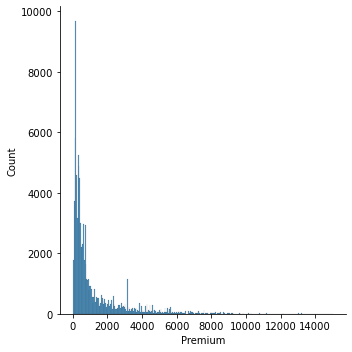

In [13]:
sns.displot(df_filter['Premium'])

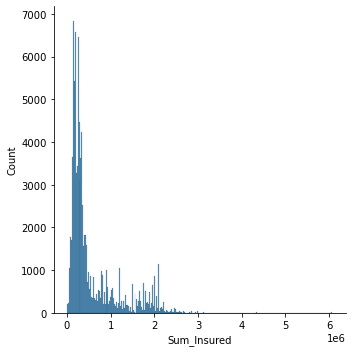

In [14]:
sns.displot(df_filter['Sum_Insured'])

### Encode the categorical features
- cm_policyholder (161)
- vehicleCategory (7)
- City (85)
- Vehicle_Make (330)
- ~Vehicle_Model (2196)~ too many features

In [15]:
cat_features = ['cm_policyholder','vehicleCategory','City','Vehicle_Make']#,'Vehicle_Model']

In [16]:
for col in cat_features:
    df_calc = df_filter.copy()
    transformed_vals = df_calc[col].apply(lambda x: str(x).lower().replace("-", " ").replace("'",""))
    df_filter.loc[:,col] = transformed_vals

In [17]:
#lst = df_filter['Vehicle_Model'].unique().tolist()
#lst = [r for r in lst if str(r)!='nan']
#lst.sort()
#lst

In [18]:
# maximum levels per category
max_levels = 150

most_frequent_categorical_levels = {}
for cat_col in cat_features:
    df_calc = df_filter.copy()
    # Calculate the levels in the category
    lvls = df_calc[cat_col].unique().tolist()
    # Set the minimum allowable levels for a categorical feature
    min_levels = [max_levels if len(lvls)>=max_levels else len(lvls)][0]    
    # Calculate the top most frequent levels in a given category
    most_frequent_levels = df_calc.groupby(by=cat_col)[cat_col].count().sort_values(ascending=False).index[0:min_levels].to_list()
    # Save the levels in a dict for later use
    most_frequent_categorical_levels[cat_col] = most_frequent_levels


for key, level_values in most_frequent_categorical_levels.items():
    df_calc = df_filter.copy()
    df_calc[key] = df_calc[key].apply(lambda x: x if x in level_values else "other")    
    df_filter[key] = df_calc[key].copy()

In [25]:
df_ohe = pd.get_dummies(df_filter[cat_features])

In [27]:
len(df_ohe.columns)

395

### Apply scaling to numeric features

In [29]:
num_features = [n for n in num_features if n in df_filter.drop('cm_gross', axis=1).columns]
num_features

['Vehicle_Year', 'Sum_Insured', 'Premium']

In [44]:
scaler  = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
df_scaled = pd.DataFrame(scaler.fit_transform(df_filter[num_features]), index=df_filter.index, columns=num_features)

### Combine

In [50]:
df_combined = df_scaled.join(df_ohe).join(df_filter[['cm_gross']])
df_combined.shape

(95203, 399)

In [52]:
relative_dir

'/Users/Sam/Documents/Financial Services/Mobility/'

In [51]:
df_combined.head()

,Vehicle_Year,Sum_Insured,Premium,cm_policyholder_a2b longhaul carriers,cm_policyholder_abc transport,cm_policyholder_ac logistics cc (uptown trading 918cc trading as),cm_policyholder_adey sleek (pty) ltd,cm_policyholder_afbuy trading cc,cm_policyholder_afri bulk,cm_policyholder_afrirent (pty) ltd,cm_policyholder_anzach freight (pty) ltd and jj van den berg and tumelo trans (pty) ltd ftrr&i,cm_policyholder_atarolog logistics pty ltd,cm_policyholder_autumn star carriers,cm_policyholder_blaizing sun investments 47 (pty) ltd & route quest (pty) ltd ftrr&i,cm_policyholder_blue falcon 13 (pty) ltd,cm_policyholder_blue horizon carriers (pty) ltd,cm_policyholder_bound for gold 45 cc (boet visser trd as),cm_policyholder_bradburys transport trading as dynamic transport,cm_policyholder_brink vervoer & verspreiding bk,cm_policyholder_brodsky trading 138 cc,cm_policyholder_buonadonna transport cc,cm_policyholder_cadifor (pty) ltd,cm_policyholder_cape finance corporation (pty) ltd,cm_policyholder_cd and sons transport (pty) ltd,cm_policyholder_cgg logistics (pty) ltd,cm_policyholder_chanzlee consulting,cm_policyholder_citoflex (pty) limited,cm_policyholder_clj van niekerk trading as van niekerk velddienste,cm_policyholder_colt logistics cc,cm_policyholder_corpclo 1071 (pty) ltd trd as hospitality express,cm_policyholder_cruise cargo (pty) ltd,cm_policyholder_devraj logistics,cm_policyholder_dmd holdings (pty) ltd,cm_policyholder_ee harris truck & bus,cm_policyholder_elleboog trust (jg van graan t as),cm_policyholder_exactrans (pty) ltd,cm_policyholder_extracity transport,cm_policyholder_f & d transport pty ltd,cm_policyholder_fairdinkem logistics,cm_policyholder_famous idea trading 55,cm_policyholder_fjj botes vervoer bk,cm_policyholder_fleet amahlu (pty) ltd,cm_policyholder_fleet bovua logistics (pty) ltd,cm_policyholder_fleet elpee’s logistics,cm_policyholder_fleet kudlane hardware,cm_policyholder_fleet lcs transport solutions (pty) ltd,cm_policyholder_fleet motsile gm transport & projects,cm_policyholder_fleet skye corporation (pty) ltd,cm_policyholder_fleet thelumusa logistics pty ltd,cm_policyholder_fleet yakha sizwe senkosi logistics,cm_policyholder_fleet yellow jersey logistics,cm_policyholder_fleet zuki dis advance intellectual (pty) ltd,cm_policyholder_fleet evolution t marc holdings (pty) ltd,cm_policyholder_fleet namathelana logistics pty ltd,cm_policyholder_fleet – bahlekile projects (pty) ltd,cm_policyholder_fleet – lcs commercial (pty( ltd,cm_policyholder_force petroleum en valinor trading,cm_policyholder_fostrans cc trd as kms transport,cm_policyholder_fraser enterprises (home base trade 97cc trading as),cm_policyholder_g du plessis tas g&w vervoer,cm_policyholder_gigafreight management solutions,cm_policyholder_guardian trucking and distribution pty ltd,cm_policyholder_hageland boerdery (pty) ltd,cm_policyholder_halin transport (pty) ltd,cm_policyholder_hd trans (pty) ltd & anzach freight & lihan trust & gariep logistics (pty) ltd & janco trust,cm_policyholder_hendrik van wyk vervoer (pty) ltd & purple rain ftrr&i,cm_policyholder_herne holdings (pty) ltd,cm_policyholder_honest logistics,cm_policyholder_honey lotus cc,cm_policyholder_honey lotus farm,cm_policyholder_interland distribution (pty) ltd,cm_policyholder_jach logistics,cm_policyholder_jaf trading cc anja familie trust a calitz,cm_policyholder_jcb transport pty ltd trd as cj partners,cm_policyholder_jlf logistics,cm_policyholder_jv ka magubela trading enterprise (pty) ltd,cm_policyholder_koster voere cc,cm_policyholder_kray holdings,cm_policyholder_kwelanga energy (pty) ltd,cm_policyholder_loutrans (pty) ltd,cm_policyholder_ludeke transport cc j and a ludeke trust epj ludeke mpunzi transport and sidepoint cc rooiblits ftrri,cm_policyholder_magamede trading and projects (pty) ltd,cm_policyholder_mainline tankers (pty) ltd,cm_policyholder_man financial services (sa) (rf) (pty) ltd,cm_policyholder_massive propco,cm_policyholder_maxims construction cc,cm_policyholder_mo

In [57]:
df_combined.to_excel('clean_data.xlsx')